# Лабораторная работа №4. Построение нейросетевого регрессора

Пан Анатолий Эдуардович<br>
Группа 932209<br>
Вариант Forest fires


Импорт необходимых модулей и библиотек

In [84]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

Загрузка данных

In [110]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
df = pd.read_csv(url)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Предобработка данных

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: 'jan' to 'dec'
   4. day - day of the week: 'mon' to 'sun'
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3
   7. DC - DC index from the FWI system: 7.9 to 860.6
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40
   12. rain - outside rain in mm/m2 : 0.0 to 6.4
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform).

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [112]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Корреляционная матрица

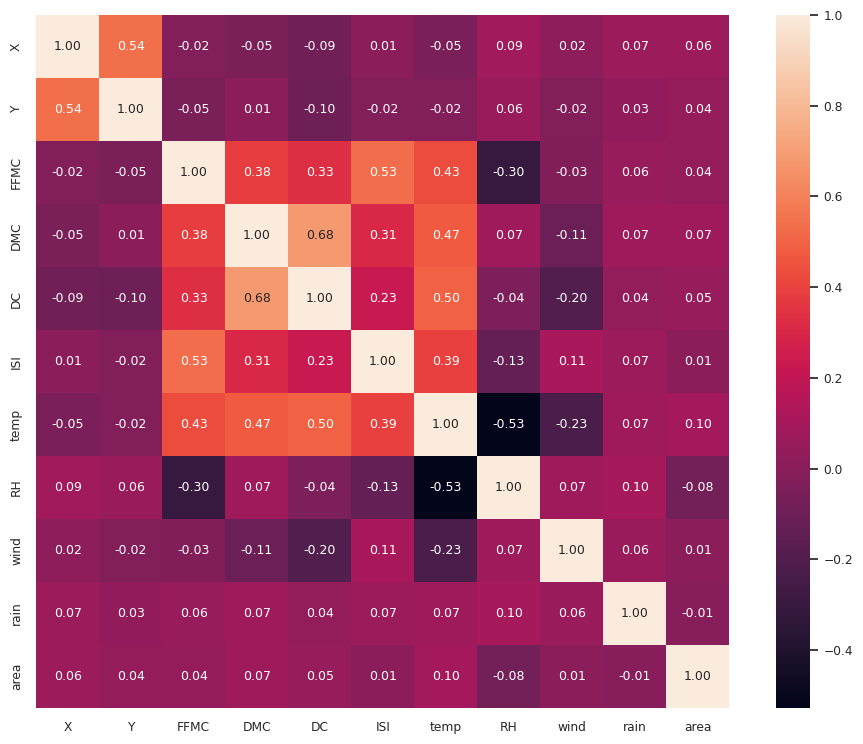

In [113]:
cols = df.drop(["month", "day"], axis=1).columns
cm = np.corrcoef(df[cols].values.T)

sns.set(font_scale=0.8)

fig, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 9},
                 yticklabels=cols,
                 xticklabels=cols
                 )
plt.show()

Коллинеарность не слишком высокая

<ipython-input-114-938d2d4a5492>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()[['area']].sort_values(by='area', ascending=False)


<Axes: >

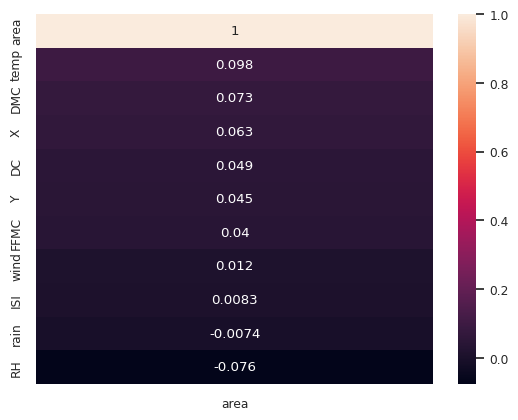

In [114]:
corr = df.corr()[['area']].sort_values(by='area', ascending=False)
sns.heatmap(corr, annot=True)

Рассмотрим target

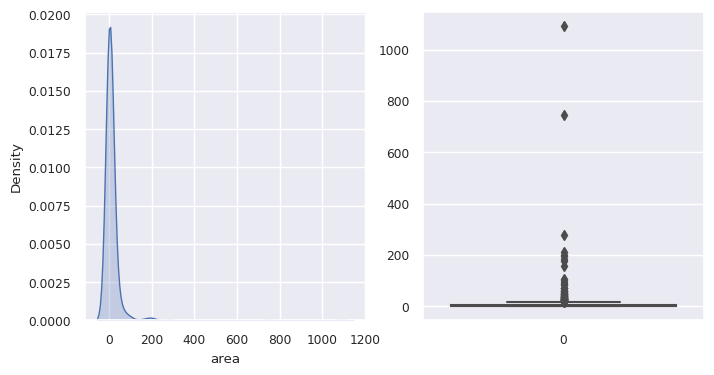

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(df['area'], fill=True, ax=ax[0])
sns.boxplot(df['area'], ax=ax[1])
fig.show()

Т.к. данные скошены вправо, то применим преобразование

$x  $→$ ln(1+$x)

Skewness: 12.846933533934868
Skewness after log transform: 1.2178376559535011


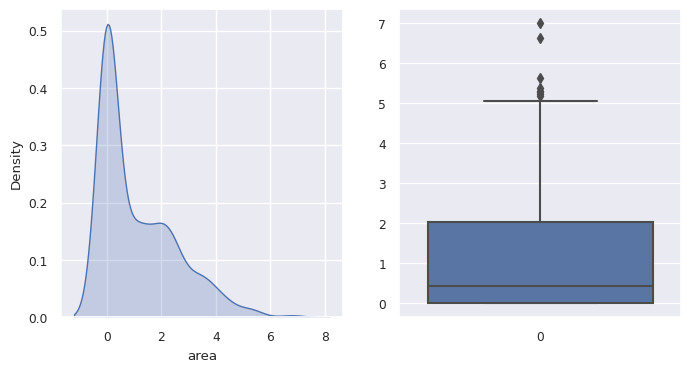

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(np.log(1+df['area']), fill=True, ax=ax[0])
sns.boxplot(np.log(1+df['area']), ax=ax[1])
fig.show()
area_log = np.log(1 + df['area'])
print('Skewness:',df['area'].skew())
print('Skewness after log transform:',area_log.skew())

Рассмотрим площадь подробнее

In [117]:
df.sort_values(['area'], ascending=[False]).head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
236,2,2,sep,sat,92.5,121.1,674.4,8.6,18.2,46,1.8,0.0,200.94
235,8,6,aug,sun,91.4,142.4,601.4,10.6,19.6,41,5.8,0.0,196.48
420,8,8,aug,wed,91.7,191.4,635.9,7.8,26.2,36,4.5,0.0,185.76
377,2,2,aug,sat,93.7,231.1,715.1,8.4,21.9,42,2.2,0.0,174.63
234,4,5,sep,sat,92.5,121.1,674.4,8.6,17.7,25,3.1,0.0,154.88
233,9,4,sep,tue,84.4,73.4,671.9,3.2,24.3,36,3.1,0.0,105.66


Совсем немного примеров с площадью возгорания более 100 га

In [118]:
df[df["area"]==0.].describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.0
mean,4.518219,4.226721,90.219028,106.679757,522.878138,8.851822,18.427935,44.894737,3.913360,0.013765,0.0
std,2.230305,1.289898,6.965969,66.300811,264.637833,4.974102,5.344018,17.581779,1.681857,0.100268,0.0
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,4.200000,15.000000,0.900000,0.000000,0.0
25%,3.000000,4.000000,90.200000,51.300000,360.100000,6.300000,15.200000,32.000000,2.700000,0.000000,0.0
50%,4.000000,4.000000,91.600000,103.200000,661.300000,8.400000,18.600000,42.000000,3.600000,0.000000,0.0
75%,6.000000,5.000000,92.600000,142.400000,706.500000,10.600000,21.600000,54.000000,5.150000,0.000000,0.0
max,9.000000,9.000000,96.200000,290.000000,855.300000,56.100000,32.400000,100.000000,8.500000,1.000000,0.0


In [119]:
df[df["area"]!=0.].describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,4.807407,4.366667,91.034074,114.707778,570.867037,9.177037,19.311111,43.733333,4.112963,0.028889,24.600185
std,2.383326,1.170740,3.709020,61.786520,229.981242,4.147350,6.179444,15.080059,1.884573,0.398392,86.501635
min,1.000000,2.000000,63.500000,3.200000,15.300000,0.800000,2.200000,15.000000,0.400000,0.000000,0.090000
25%,3.000000,4.000000,90.325000,82.900000,486.500000,6.800000,16.125000,33.000000,2.700000,0.000000,2.140000
50%,5.000000,4.000000,91.700000,111.700000,665.600000,8.400000,20.100000,41.000000,4.000000,0.000000,6.370000
75%,7.000000,5.000000,92.975000,141.300000,721.325000,11.375000,23.400000,53.000000,4.900000,0.000000,15.422500
max,9.000000,9.000000,96.200000,291.300000,860.600000,22.700000,33.300000,96.000000,9.400000,6.400000,1090.840000


Средние значения: DC выше при ненулевом уроне, в остальном различия невелики

Минимальные значения: Значительно выше FFMC для ненулевого урона. Также немного выше DC. Но минимальная температура, как ни странно, выше для случаев с нулевыми повреждениями.

Максимальные значения: Максимальный ISI выше для случая с нулевым ущербом. Максимальный дождь также, как ни странно, выше для случая больших повреждений.

Признаки

In [120]:
dfa = df.drop(columns='area')
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()
print('Categorical features:', cat_columns)
print('Numerical features:', num_columns)

Categorical features: ['month', 'day']
Numerical features: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


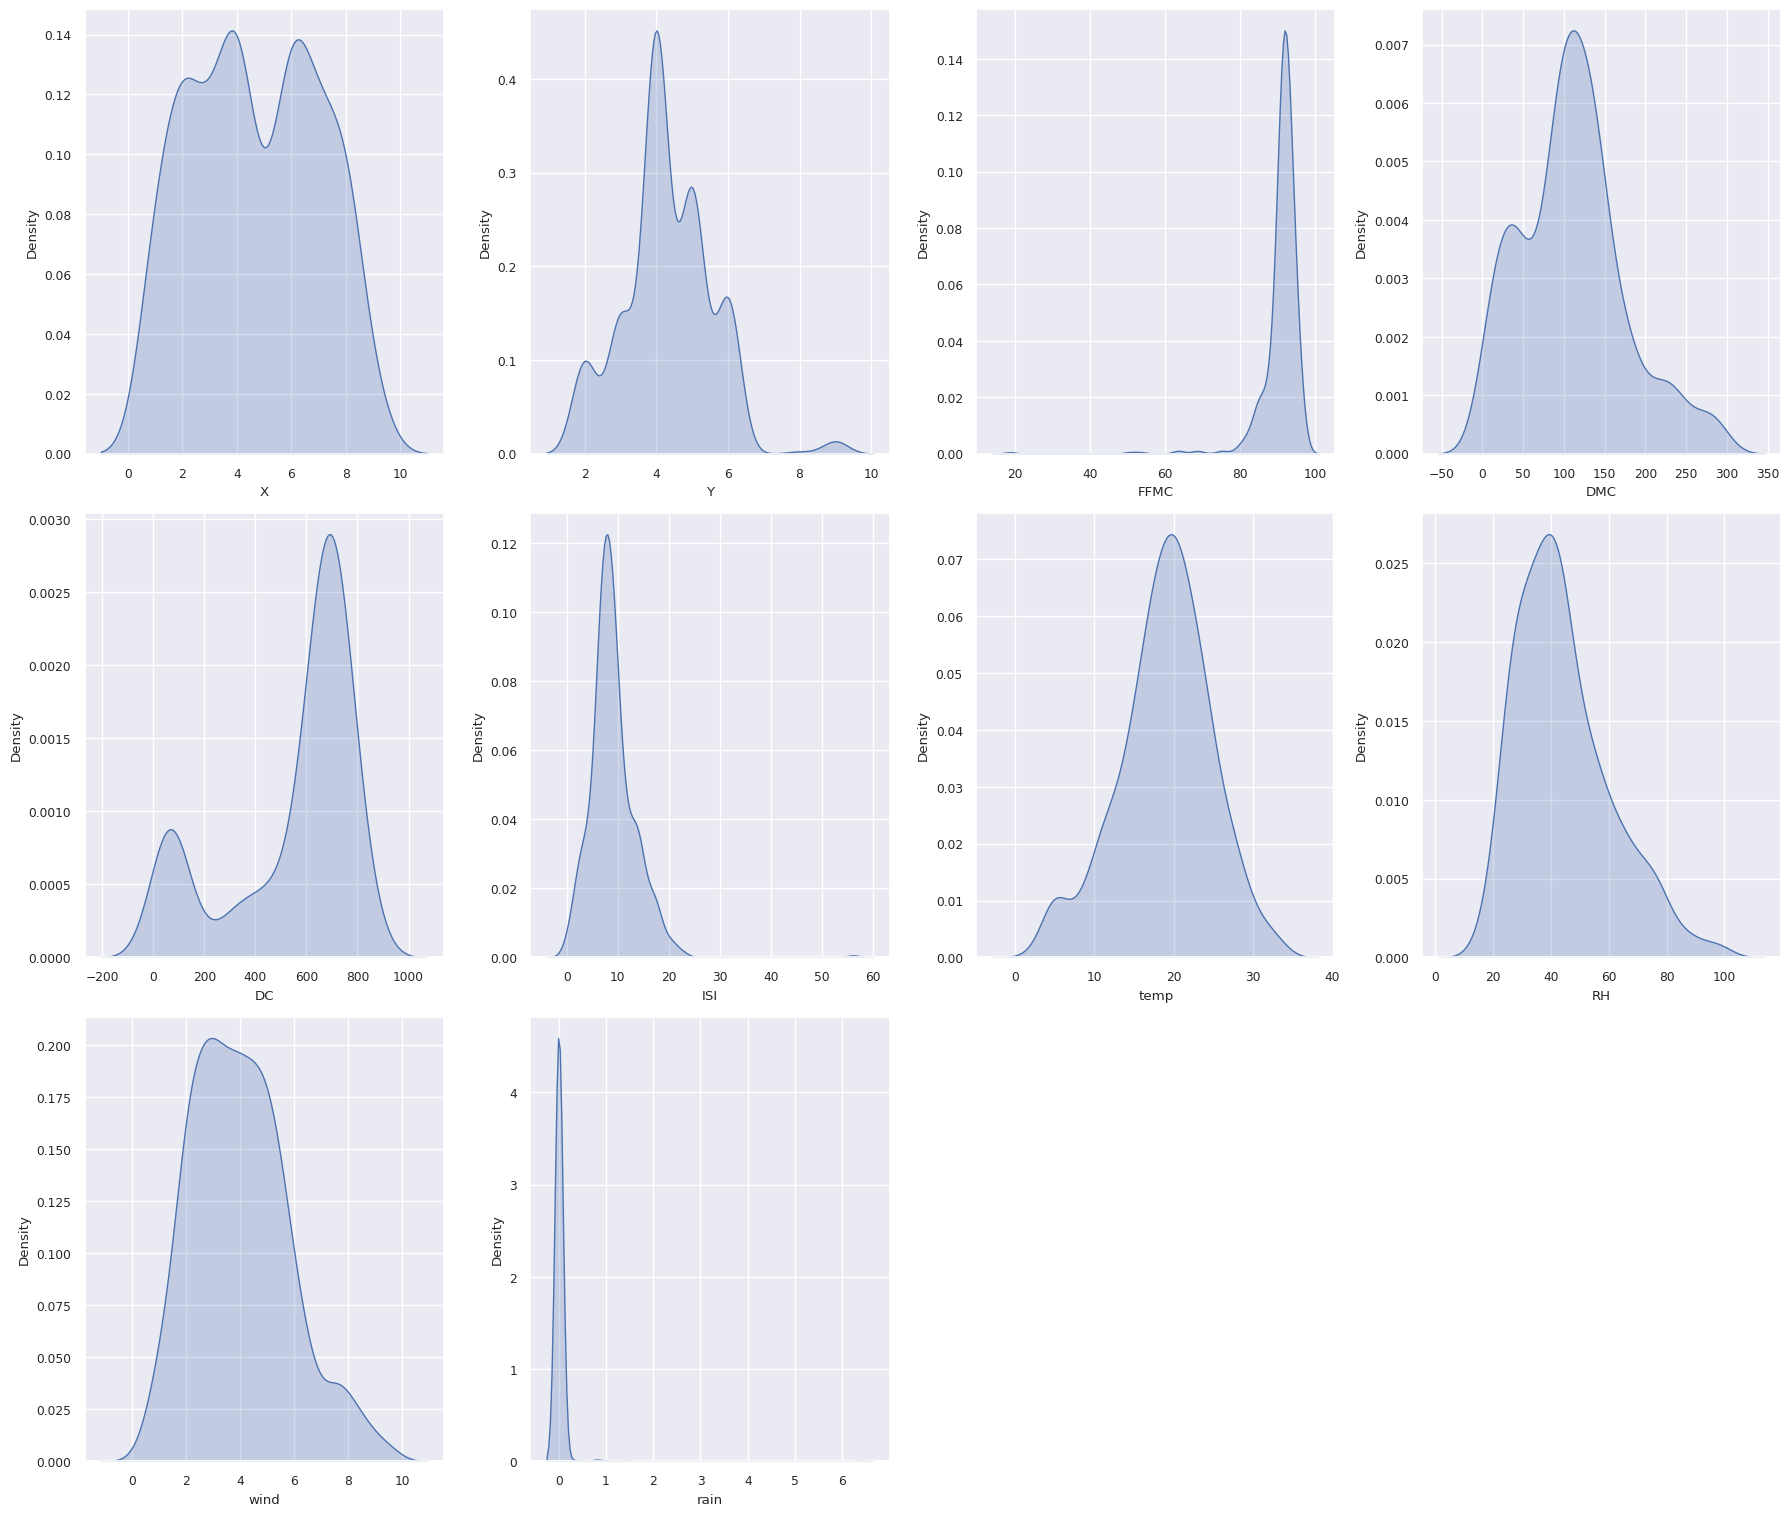

In [121]:
plt.figure(figsize=(18,40))
for i, col in enumerate(num_columns, 1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col], fill=True)
plt.tight_layout()
plt.show()

temp, RH, wind похожи на гауссово распределение

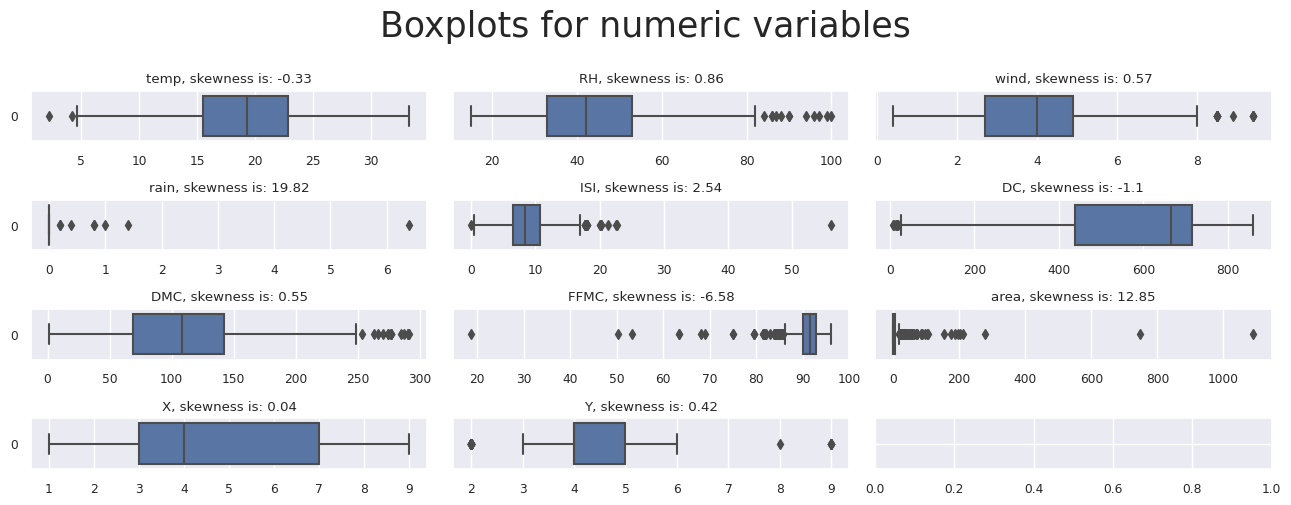

In [122]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(13,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

numerical_columns = list(df.loc[:,['temp','RH','wind','rain','ISI','DC','DMC',
                 'FFMC','area','X','Y' ]])

boxplots_custom(dataset=df, columns_list=numerical_columns, rows=4, cols=3, suptitle='Boxplots for numeric variables')
plt.tight_layout()

FFMC, ISI, rain сильно скошены, как и area

Проверим распределение по месяцам и дням

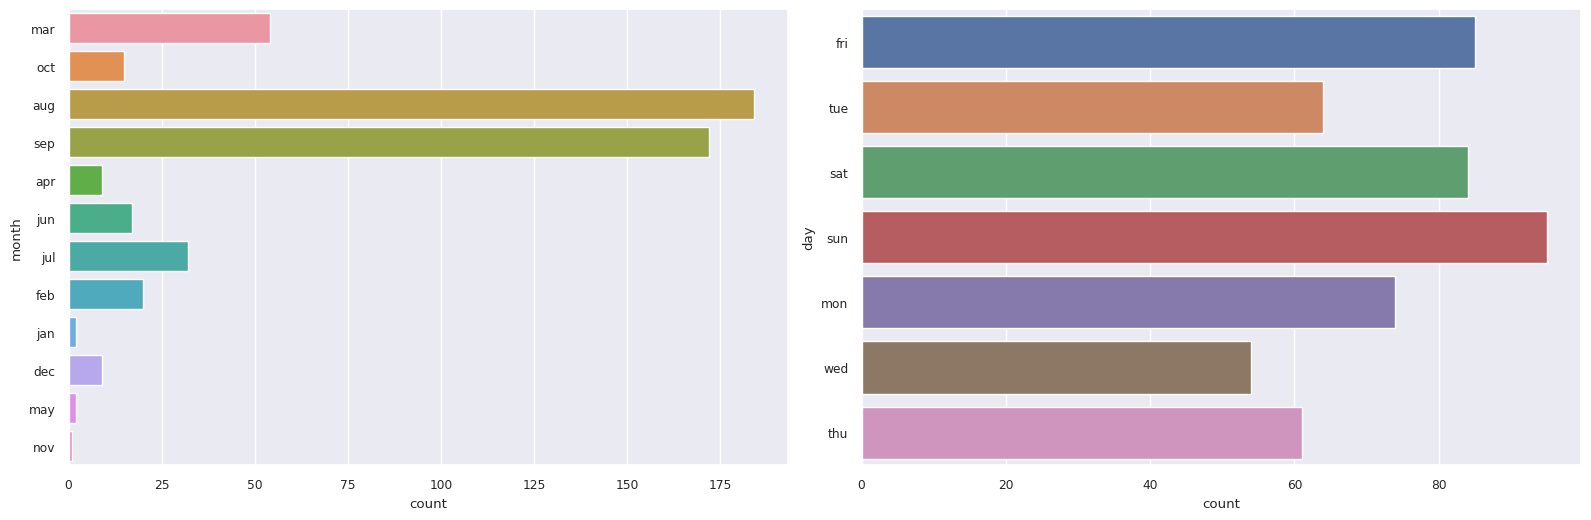

In [123]:
plt.figure(figsize=(16, 10))
for i,col in enumerate(cat_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, y=col)
plt.tight_layout()
plt.show()

In [124]:
print('Number of rows with no damage:',df[df['area'] == 0.].shape[0])
print('Number of rows with damage:',df[df['area'] != 0.].shape[0])

Number of rows with no damage: 247
Number of rows with damage: 270


One hot encoding для категориальных переменных

In [125]:
df = pd.get_dummies(df, columns=['day', 'month'], drop_first=True)

Трансформируем таргет

In [132]:
# Log transform
df['area'] = np.log(1 + df['area'])

# Creating bins of in the target, to stratify in train/test split
X = df.drop(columns='area')
y = df['area'].values.reshape(-1, 1)

In [133]:
X

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,0,1,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,0,1,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,0,1,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0


___

Разделим выборки

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Масштабирование

In [135]:
sc_feature = StandardScaler()
sc_target = StandardScaler()

# transforming features
X_test = sc_feature.fit_transform(X_test)
X_train = sc_feature.transform(X_train)

# transforming target
y_test = sc_target.fit_transform(y_test)
y_train = sc_target.transform(y_train)

In [136]:
# features
X_test = pd.DataFrame(X_test, columns=X.columns)
X_train = pd.DataFrame(X_train, columns=X.columns)

# target
y_test = pd.DataFrame(y_test, columns=["area"])
y_train = pd.DataFrame(y_train, columns=["area"])

Сохраним полученное

In [137]:
path = "/content/drive/MyDrive/masters/Neural_networks/lab_4/"

X_train.to_csv(path + "X_train.csv")
X_test.to_csv(path + "X_test.csv")

y_train.to_csv(path + "y_train.csv")
y_test.to_csv(path + "y_test.csv")

In [138]:
X_train = pd.read_csv(path + "X_train.csv", index_col=0)
X_test = pd.read_csv(path + "X_test.csv", index_col=0)

y_train = pd.read_csv(path + "y_train.csv", index_col=0)
y_test = pd.read_csv(path + "y_test.csv", index_col=0)

Начнем моделировать нейросеть

In [187]:
model = keras.Sequential([
    keras.layers.Dense(16, input_dim=X_train.shape[1], activation="linear"),
    keras.layers.Dense(16, activation="linear"),
    keras.layers.Dense(8, activation="linear"),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(1, activation="relu")
])

In [188]:
model.compile(optimizer="adam",
              loss="mse")

In [189]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                    batch_size = 10, epochs = 100)

Epoch 1/100
42/42 [==============================] - 1s 6ms/step - loss: 2.2872 - val_loss: 1.5292
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 1.2514 - val_loss: 1.2847
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 1.0303 - val_loss: 1.1552
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 1.0734 - val_loss: 1.1153
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.9251 - val_loss: 1.0857
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.9367 - val_loss: 1.0736
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.9299 - val_loss: 1.0673
Epoch 8/100
42/42 [==============================] - 0s 3ms/step - loss: 0.9240 - val_loss: 1.0619
Epoch 9/100
42/42 [==============================] - 0s 3ms/step - loss: 0.9138 - val_loss: 1.0714
Epoch 10/100
42/42 [==============================] - 0s 4ms/step - loss: 0.9518 - val_loss: 1.0832
Epoch 11/

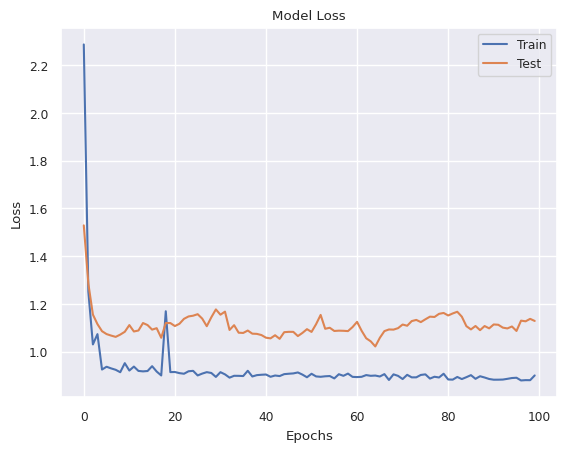

In [190]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])

Наблюдается переобучение, можно меньше эпох взять

In [191]:
model = keras.Sequential([
    keras.layers.Dense(16, input_dim=X_train.shape[1], activation="linear"),
    keras.layers.Dense(8, activation="linear"),
    keras.layers.Dense(4, activation="linear"),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(1, activation="relu")
])

In [192]:
model.compile(optimizer="adam",
              loss="mse")

In [193]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                    batch_size = 10, epochs = 20)

Epoch 1/20
42/42 [==============================] - 1s 7ms/step - loss: 1.7333 - val_loss: 1.2147
Epoch 2/20
42/42 [==============================] - 0s 3ms/step - loss: 1.0543 - val_loss: 1.0199
Epoch 3/20
42/42 [==============================] - 0s 3ms/step - loss: 0.9749 - val_loss: 0.9666
Epoch 4/20
42/42 [==============================] - 0s 3ms/step - loss: 0.9568 - val_loss: 0.9685
Epoch 5/20
42/42 [==============================] - 0s 3ms/step - loss: 0.9772 - val_loss: 0.9644
Epoch 6/20
42/42 [==============================] - 0s 3ms/step - loss: 0.9596 - val_loss: 0.9671
Epoch 7/20
42/42 [==============================] - 0s 3ms/step - loss: 1.0482 - val_loss: 0.9629
Epoch 8/20
42/42 [==============================] - 0s 4ms/step - loss: 0.9309 - val_loss: 0.9659
Epoch 9/20
42/42 [==============================] - 0s 3ms/step - loss: 0.9342 - val_loss: 0.9623
Epoch 10/20
42/42 [==============================] - 0s 3ms/step - loss: 0.9465 - val_loss: 0.9653
Epoch 11/20
42/42 [

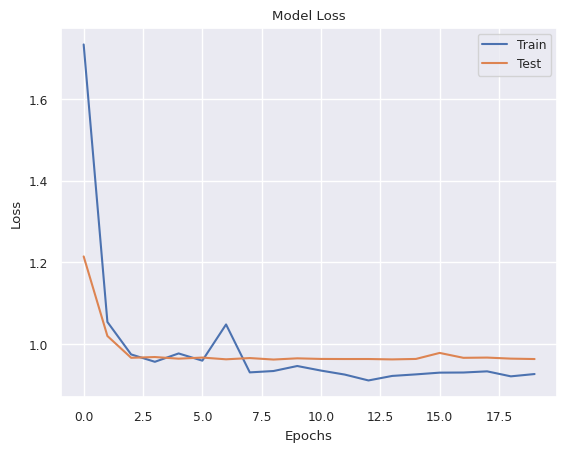

In [194]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])

Рассчитаем RMSE и r2 (коэффицент детерминации)

In [195]:
pred = model.predict(X_test)

print('RMSE is:', 1.0287 ** 0.5, 'and the r2 is:', r2_score(y_test, pred))

4/4 [==============================] - 0s 4ms/step
RMSE is: 1.014248490262618 and the r2 is: 0.03644840715301334


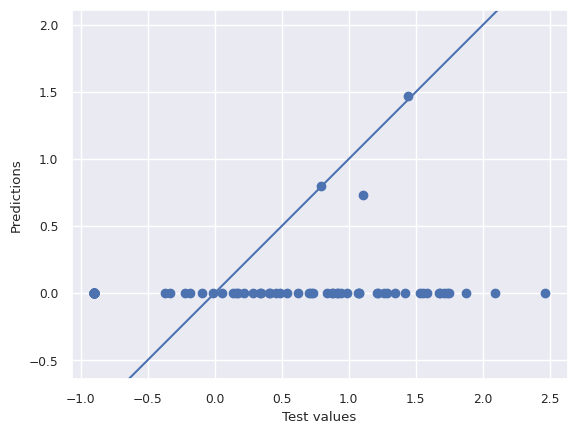

In [196]:
plt.scatter(y_test, pred)
plt.xlabel('Test values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()